# Demo 06 — PDE pricing and PDE-vs-Black–Scholes diagnostics

This demo notebook shows how to:

1. **Price** a European vanilla option using your **finite-difference PDE pricer**.
2. **Validate** the PDE solver against the **Black–Scholes closed form** (same model, different numerics).
3. Run **convergence sweeps** over grid/time resolution.
4. Produce a **decision-oriented report**: error vs runtime, feasibility under tolerances, and a Pareto frontier.

> Assumption: you have implemented the PDE pricer + diagnostics modules under:
> - `option_pricing.pricers.pde_pricer.bs_price_pde_european`
> - `option_pricing.diagnostics.pde_vs_bs` (strict layering: compute executes, tables/plots transform only)


In [1]:
from __future__ import annotations

import sys
from pathlib import Path


def _maybe_add_repo_src_to_path() -> None:
    here = Path().resolve()
    for parent in [here, *here.parents]:
        candidate = parent / "src" / "option_pricing"
        if candidate.exists():
            sys.path.insert(0, str(parent / "src"))
            return


_maybe_add_repo_src_to_path()


## Imports

In [2]:
from dataclasses import replace

# plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from option_pricing import MarketData, OptionSpec, OptionType, PricingInputs, bs_price

# PDE pricer + domain config
try:
    from option_pricing.pricers.pde.domain import BSDomainConfig, BSDomainPolicy, Coord
    from option_pricing.pricers.pde_pricer import bs_price_pde_european
except ImportError as e:
    raise ImportError(
        "This demo expects your PDE pricer modules to exist. "
        "Implement option_pricing/pricers/pde_pricer.py and option_pricing/pricers/pde/domain.py first."
    ) from e

# Diagnostics (strict layering)
from option_pricing.diagnostics.pde_vs_bs.cases import default_cases
from option_pricing.diagnostics.pde_vs_bs.compute import (
    run_cases,
    run_once,
    sweep_nt,
    sweep_nx,
    sweep_nx_nt,
)
from option_pricing.diagnostics.pde_vs_bs.plots import (
    plot_convergence,
    plot_error_vs_runtime,
    plot_price_scatter,
)
from option_pricing.diagnostics.pde_vs_bs.tables import (
    add_decision_columns,
    best_feasible_row,
    order_columns,
    pareto_frontier,
    to_frame,
)


## 1) Define a pricing scenario

In [3]:
market = MarketData(spot=100.0, rate=0.02, dividend_yield=0.00)

# 1Y European ATM call
spec = OptionSpec(kind=OptionType.CALL, strike=100.0, expiry=1.0)

p = PricingInputs(spec=spec, market=market, sigma=0.20)

bs = bs_price(p)
bs


8.916037278572537

## 2) Domain configuration (grid bounds + spacing policy)

This demo tries to be robust to small changes in `BSDomainConfig`. It will: 
- inspect dataclass fields if available, 
- populate a reasonable default configuration.

In [4]:

domain_cfg = BSDomainConfig(
    policy=BSDomainPolicy.LOG_NSIGMA,
    spacing="clustered",
    cluster_strength=2.0,
    n_sigma=10.0,                 # if your policy uses sigma-based bounds
)


# 3.1) PDE pricer solo run

In [5]:
C_bs = bs_price_pde_european(
    p=p,
    domain_cfg=domain_cfg,
)
print(C_bs)

8.91697472211806


## 3.2) Single-run PDE vs BS (timed)

This is the simplest correctness check: same model, different solution method.

In [6]:
res = run_once(
    p,
    domain_cfg=domain_cfg,
    Nx=401,
    Nt=401,
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
)
res


PDEvsBSRun(method='cn', coord='logS', spacing='clustered', advection=<AdvectionScheme.CENTRAL: 'central'>, Nx=401, Nt=401, x0=4.605170185988092, bs=8.916037278572537, pde=8.915263324381007, abs_err=0.0007739541915299242, rel_err=8.680472808137863e-05, runtime_ms=685.4547000257298)

### Optional: pull the full PDE solution and inspect the terminal slice

In [7]:
(res2, sol) = run_once(
    p,
    domain_cfg=domain_cfg,
    Nx=401,
    Nt=401,
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
    return_solution=True,
)

print(res2)
print("grid sizes (Nx, Nt):", res2.Nx, res2.Nt)


PDEvsBSRun(method='cn', coord='logS', spacing='clustered', advection=<AdvectionScheme.CENTRAL: 'central'>, Nx=401, Nt=401, x0=4.605170185988092, bs=8.916037278572537, pde=8.915263324381007, abs_err=0.0007739541915299242, rel_err=8.680472808137863e-05, runtime_ms=688.6845999979414)
grid sizes (Nx, Nt): 401 401


## 4) Show solver options: method × advection

Supported by `solve_pde_1d`: `method ∈ {cn, implicit, explicit}` and `advection ∈ {central, upwind}`.

In [8]:
records = []
for method in ["cn", "implicit", "explicit"]:
    for adv in ["central", "upwind"]:
        r = run_once(
            p,
            domain_cfg=domain_cfg,
            Nx=401,
            Nt=401,
            coord=Coord.LOG_S,
            method=method,
            advection=adv,
            spacing=getattr(domain_cfg, "spacing", "clustered"),
        )
        d = r.__dict__ if hasattr(r, "__dict__") else {
            k: getattr(r, k) for k in r.__slots__
        }
        records.append({"variant": f"{method}/{adv}", **d})

df_opts = pd.DataFrame(records).sort_values("abs_err")
df_opts[["variant", "runtime_ms", "abs_err", "rel_err", "pde", "bs"]]


,variant,runtime_ms,abs_err,rel_err,pde,bs
0,cn/central,717.5985,7.739542e-04,8.680473e-05,8.915263e+00,8.916037
1,cn/upwind,755.3639,7.739542e-04,8.680473e-05,8.915263e+00,8.916037
2,implicit/central,663.5912,3.342095e-03,3.748408e-04,8.912695e+00,8.916037
3,implicit/upwind,718.4850,3.342095e-03,3.748408e-04,8.912695e+00,8.916037
4,explicit/central,663.7399,3.780926e+295,4.240591e+294,-3.780926e+295,8.916037
5,explicit/upwind,721.9057,3.780926e+295,4.240591e+294,-3.780926e+295,8.916037


## 5) Convergence sweeps (Nx, Nt, and Nx×Nt)

These sweeps are the fastest way to distinguish a solver issue from a configuration issue.

In [9]:
rec_nx = sweep_nx(
    p,
    domain_cfg=domain_cfg,
    Nx_list=(51, 101, 201, 401, 801),
    Nt=401,
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
)

df_nx = order_columns(to_frame(rec_nx))
df_nx[["Nx", "Nt", "abs_err", "runtime_ms"]]


,Nx,Nt,abs_err,runtime_ms
0,51,401,0.050075,330.1005
1,101,401,0.012433,307.8581
2,201,401,0.003102,444.2216
3,401,401,0.000774,676.3419
4,801,401,0.000192,1129.5062


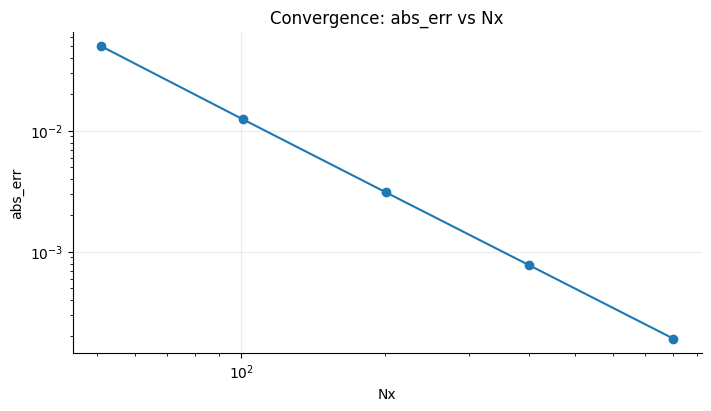

In [10]:
fig, ax = plot_convergence(df_nx, x_col="Nx", y_col="abs_err")
plt.show()


In [11]:
rec_nt = sweep_nt(
    p,
    domain_cfg=domain_cfg,
    Nt_list=(21, 51, 101, 201, 401),
    Nx=401,
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
)

df_nt = order_columns(to_frame(rec_nt))
df_nt[["Nx", "Nt", "abs_err", "runtime_ms"]]


,Nx,Nt,abs_err,runtime_ms
0,401,21,0.054393,49.4496
1,401,51,0.001564,142.6363
2,401,101,0.000750,164.9482
3,401,201,0.000769,331.9930
4,401,401,0.000774,700.3101


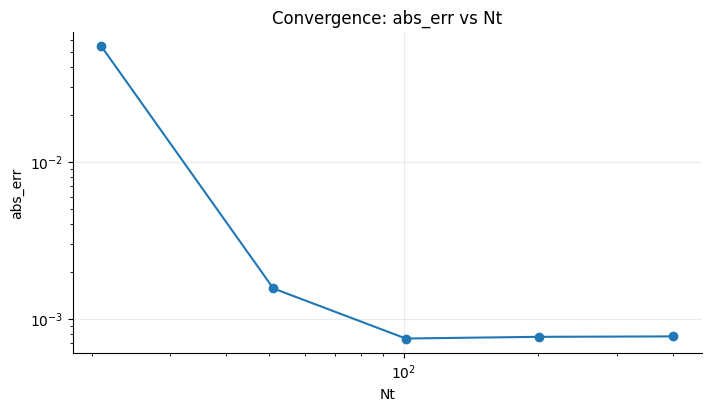

In [12]:
fig, ax = plot_convergence(df_nt, x_col="Nt", y_col="abs_err")
plt.show()


### Nx×Nt grid (error vs runtime, Pareto frontier)

In [13]:
rec_grid = sweep_nx_nt(
    p,
    domain_cfg=domain_cfg,
    Nx_list=(101, 201, 401, 801),
    Nt_list=(51, 101, 201, 401),
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
)

df_grid = order_columns(to_frame(rec_grid))

# Add feasibility columns (decision knobs)
df_grid2 = add_decision_columns(df_grid, tol_abs=1e-4, tol_rel=1e-4, budget_ms=None)

# Pareto set (minimize runtime and abs_err)
df_pf = pareto_frontier(df_grid2, x_col="runtime_ms", y_col="abs_err")

print("grid rows:", len(df_grid2))
print("pareto rows:", len(df_pf))

df_pf[["Nx", "Nt", "runtime_ms", "abs_err", "rel_err"]].sort_values("runtime_ms")


grid rows: 16
pareto rows: 6


,Nx,Nt,runtime_ms,abs_err,rel_err
0,101,51,51.0673,0.012333,0.001383
4,201,51,59.2825,0.003003,0.000337
8,401,51,85.2655,0.001564,0.000175
9,401,101,169.5500,0.000750,0.000084
13,801,101,290.5036,0.000614,0.000069
14,801,201,581.7369,0.000188,0.000021


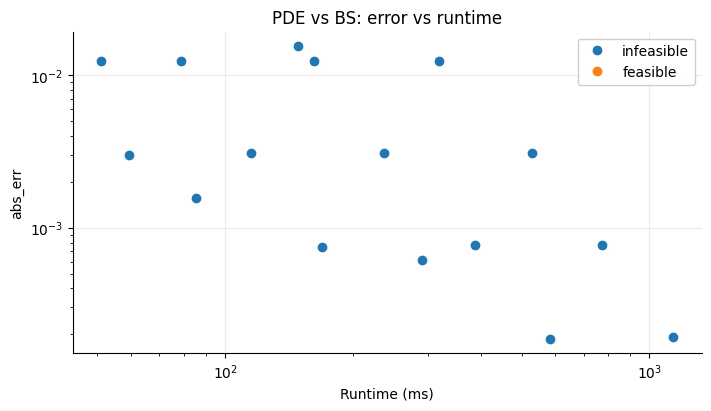

In [14]:
fig, ax = plot_error_vs_runtime(df_grid2)
plt.show()


## 5b) Advanced: direct solver control (theta-scheme and `store="all"`)

The PDE **pricer** (`bs_price_pde_european`) intentionally hides most solver knobs to keep pricing calls simple.
For diagnostics (and for developing new schemes), it is often useful to call the **core solver** directly:

- choose an arbitrary theta value (beyond explicit/CN/implicit)
- choose `store="all"` to retain the full time history `U[t, x]`

> This section is optional; it requires your `bs_pde_wiring` + `compute_bounds` helpers.


U shape (Nt x Nx): (151, 151)


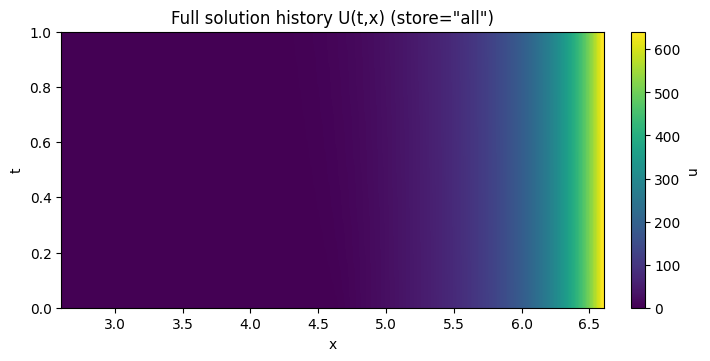

In [22]:
from option_pricing.numerics.grids import GridConfig
from option_pricing.numerics.pde import AdvectionScheme, ThetaMethod, solve_pde_1d

try:
    from option_pricing.pricers.pde.domain import bs_compute_bounds
    from option_pricing.pricers.pde.european_black_scholes import bs_pde_wiring
except ImportError:
    print('Skipping: bs_pde_wiring/compute_bounds not available.')
else:
    bounds = bs_compute_bounds(p, coord=Coord.LOG_S, cfg=domain_cfg)
    wiring = bs_pde_wiring(p, Coord.LOG_S, x_lb=bounds.x_lb, x_ub=bounds.x_ub)

    # Smaller grid for demo purposes (store='all' is O(Nx*Nt) memory)
    grid_cfg_small = GridConfig(
        Nx=151,
        Nt=151,
        x_lb=bounds.x_lb,
        x_ub=bounds.x_ub,
        T=p.tau,
        spacing=getattr(domain_cfg, 'spacing', 'clustered'),
        x_center=bounds.x_center,
        cluster_strength=getattr(domain_cfg, 'cluster_strength', 2.0),
    )

    # Example: theta-scheme with theta=0.55 (slightly more implicit than CN)
    sol_all = solve_pde_1d(
        wiring.problem,
        grid_cfg=grid_cfg_small,
        method=ThetaMethod(theta=0.55),
        advection=AdvectionScheme.CENTRAL,
        store='all',
    )

    U = np.asarray(sol_all.u, dtype=float)
    x = np.asarray(sol_all.grid.x, dtype=float)
    t = np.asarray(sol_all.grid.t, dtype=float)
    print('U shape (Nt x Nx):', U.shape)

    # Visualize the full time history as a heatmap
    fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), constrained_layout=True)
    im = ax.imshow(
        U,
        aspect='auto',
        origin='lower',
        extent=[x.min(), x.max(), t.min(), t.max()],
    )
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title('Full solution history U(t,x) (store="all")')
    fig.colorbar(im, ax=ax, label='u')
    plt.show()


## 6) Case suite (regression-style diagnostics)

Run a curated set of cases and look for outliers.

In [23]:
cases = default_cases(S0=100.0, include_stress=True)
records_cases = run_cases(
    cases,
    domain_cfg=domain_cfg,
    Nx=401,
    Nt=401,
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
)

df_cases = order_columns(to_frame(records_cases))
df_cases[["case", "kind", "tau", "strike", "sigma", "abs_err", "runtime_ms"]].sort_values("abs_err", ascending=False).head(12)


,case,kind,tau,strike,sigma,abs_err,runtime_ms
76,call_atm_veryhighvol_6m,call,0.50,100.0,1.2,0.005520,743.7700
77,put_atm_veryhighvol_6m,put,0.50,100.0,1.2,0.003608,814.1299
68,call_ATM_1y_high,call,1.00,100.0,0.5,0.002204,761.8329
69,put_ATM_1y_high,put,1.00,100.0,0.5,0.002039,759.6985
75,put_deep_otm_highvol_long,put,2.00,50.0,0.8,0.001902,711.7755
67,put_OTM_1y_high,put,1.00,110.0,0.5,0.001337,718.9844
70,call_ITM_1y_high,call,1.00,90.0,0.5,0.001216,767.6771
50,call_ATM_3m_high,call,0.25,100.0,0.5,0.001026,734.6643
51,put_ATM_3m_high,put,0.25,100.0,0.5,0.001015,690.9781
74,call_deep_itm_highvol_long,call,2.00,50.0,0.8,0.000976,789.5644


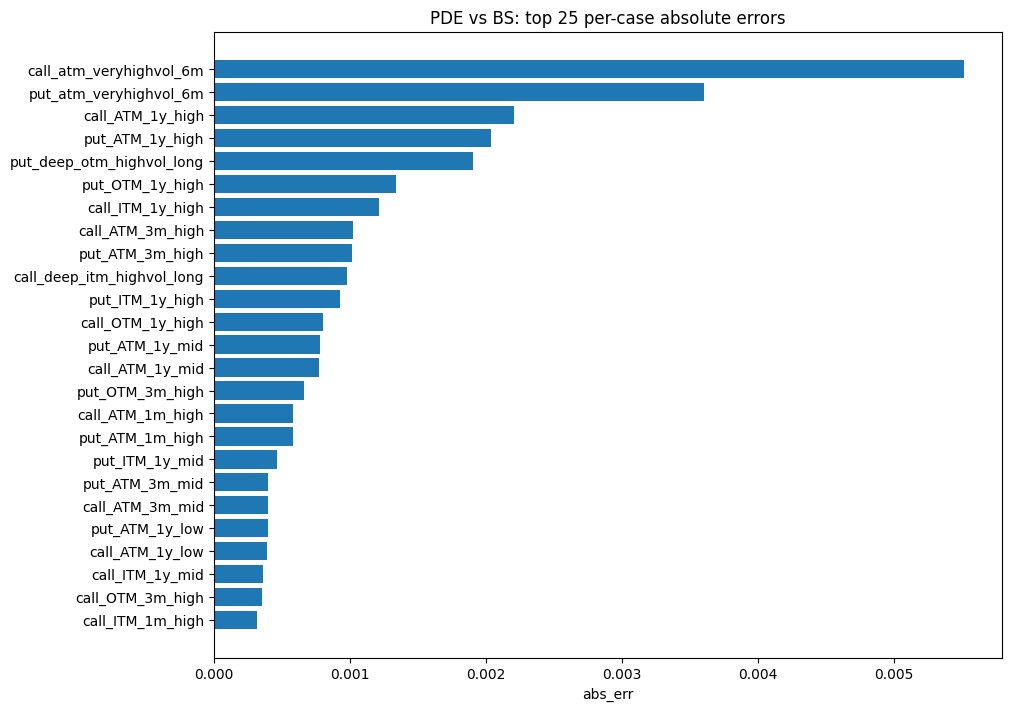

In [24]:

d = df_cases.sort_values("abs_err", ascending=False).reset_index(drop=True)

N = 25  # show top N worst cases
top = d.head(N).iloc[::-1]  # reverse so worst is at the top in barh

fig, ax = plt.subplots(1, 1, figsize=(10, 7), constrained_layout=True)
ax.barh(top["case"], top["abs_err"])
ax.set_xlabel("abs_err")
ax.set_title(f"PDE vs BS: top {N} per-case absolute errors")
plt.show()


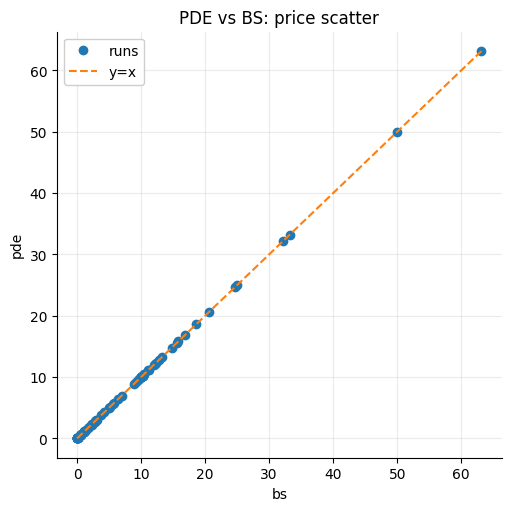

In [25]:
fig, ax = plot_price_scatter(df_cases, x_col="bs", y_col="pde")
plt.show()


## 7) Full-curve check (PDE slice vs BS curve on the same grid)

This helps distinguish point-extraction issues from global solution issues.

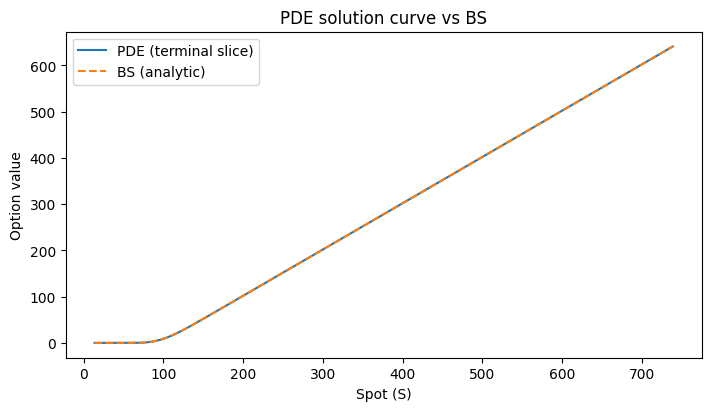

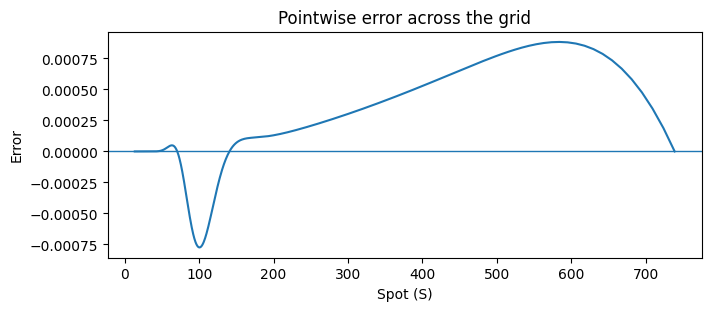

In [26]:
(res_full, sol_full) = run_once(
    p,
    domain_cfg=domain_cfg,
    Nx=401,
    Nt=401,
    coord=Coord.LOG_S,
    method="cn",
    advection="central",
    spacing=getattr(domain_cfg, "spacing", "clustered"),
    return_solution=True,
)

x = np.asarray(sol_full.grid.x, dtype=float)
u_pde = np.asarray(sol_full.u_final, dtype=float)

# Map x -> S for BS curve
coord_used = Coord.LOG_S  # matches the coord passed to run_once above
S_grid = np.exp(x) if coord_used == Coord.LOG_S else x

# Compute BS along the grid (scalar pricer; fine for demo sizes)
bs_grid = []
for Si in S_grid:
    market_i = replace(p.market, spot=float(Si))
    p_i = PricingInputs(spec=p.spec, market=market_i, sigma=p.sigma, t=getattr(p, "t", 0.0))
    bs_grid.append(float(bs_price(p_i)))

bs_grid = np.asarray(bs_grid, dtype=float)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), constrained_layout=True)
ax.plot(S_grid, u_pde, label="PDE (terminal slice)")
ax.plot(S_grid, bs_grid, ls="--", label="BS (analytic)")
ax.set_xlabel("Spot (S)")
ax.set_ylabel("Option value")
ax.set_title("PDE solution curve vs BS")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True)
ax.plot(S_grid, u_pde - bs_grid, label="PDE - BS")
ax.axhline(0.0, lw=1.0)
ax.set_xlabel("Spot (S)")
ax.set_ylabel("Error")
ax.set_title("Pointwise error across the grid")
plt.show()


## 8) Decision-oriented summary

Given tolerances (accuracy) and optional runtime budget, pick the fastest feasible configuration.

In [20]:
df_dec = add_decision_columns(df_grid, tol_abs=1e-4, tol_rel=1e-4, budget_ms=5.0)
best_idx = best_feasible_row(df_dec)

if best_idx is None:
    print("No configuration met tolerance within budget. Prefer BS for this product class (or adjust domain/grid).")
else:
    best = df_dec.loc[best_idx]
    print("Best feasible config under budget:")
    display(best[["Nx", "Nt", "runtime_ms", "abs_err", "rel_err", "method", "advection", "coord"]])


No configuration met tolerance within budget. Prefer BS for this product class (or adjust domain/grid).
